# Working with MEG dataset
MEG dataset from THINGS initiative: https://openneuro.org/datasets/ds004212/versions/2.0.1
### Training data partition
The data is .fif file which needs to be converted into a rather easy to use .npy array.
We will use mne library for this: https://mne.tools/dev/index.html 


We collected extensively sampled object representations using magnetoencephalography (MEG). To this end, we drew on the THINGS database (Hebart et al., 2019), a richly-annotated database of 1,854 object concepts representative of the American English language which contains 26,107 manually-curated naturalistic object images.

ERP = event-related potential; signal with respect to some event
VEP = ERP for visual stimuli



27084 events, 281 time points, 271 channels

## Here we perform NMF experiements. And data matrix as concepts x channes*time

Create clusters of decomposed time components of meg data over multiple seeds.
First time proper implementation of H and W consensus!


In [1]:
import numpy as np # type: ignore
import mne, os # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.image as mpimg # type: ignore
import nimfa # type: ignore
import scipy.stats as st # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.decomposition import NMF # type: ignore
from scipy.spatial.distance import cdist # type: ignore
from scipy.optimize import nnls  # type: ignore     
from sklearn.linear_model import LinearRegression # type: ignore

### Functions

In [2]:
def compute_log_likelihood(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute log-likelihood."""
    V_hat = np.dot(W, H)
    err_std_dev = np.sqrt(np.var(V - V_hat))
    log_likelihood = st.norm.logpdf(V, loc=V_hat, scale=err_std_dev).sum()
    return log_likelihood

def compute_aic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute AIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    aic = 2 * n_free_params - 2 * log_likelihood
    return aic, n_free_params

def compute_bic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute BIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    I, J = V.shape
    n_samples = I * J
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    bic = np.log(n_samples) * n_free_params - 2 * log_likelihood
    return bic

def fit_bnmf(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=500, min_residuals=1e-4, alpha=np.zeros((V.shape[0], k)),
                        beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=100, stride=1,
                        n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = bnmf_fit.basis()
    H = bnmf_fit.coef()
    return np.array(W), np.array(H)

def compute_evar_all(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    V_hat = np.dot(W, H)
    rss = np.sum(np.asarray(V_hat - V)**2)
    evar_all = 1. - rss / (V*V).sum()
    return evar_all

def compute_evar_indiv(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int):
    V_hat_d = np.outer(W[:, d], H[d, :])
    rss = np.sum(np.asarray(V_hat_d - V)**2)
    evar_indiv = 1. - rss / (V*V).sum()
    return evar_indiv

def compute_evar_unique(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int, evar_all: float):
    V_hat_wo_d = np.dot(W[:, np.arange(W.shape[1]) != d], H[np.arange(H.shape[0]) != d, :])
    rss = np.sum(np.asarray(V_hat_wo_d - V)**2)
    evar_rest = 1. - rss / (V*V).sum()
    evar_unique = evar_all - evar_rest
    return evar_unique

def load_epochs(preproc_dir,all_epochs = []):
    for p in range(1,n_participants+1):
        epochs = mne.read_epochs(f'{preproc_dir}/preprocessed_P{str(p)}-epo.fif', preload=False)
        all_epochs.append(epochs)
    return all_epochs

def plot_erfs(epochs,n_sessions,name):
    ctf_layout = mne.find_layout(epochs.info)
    picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
    picks = np.where([i[2]==name for i in ctf_layout.names])[0]
    plt.figure(figsize=(10,5))
    # get evoked data
    for s in range(n_sessions):    
        evoked = epochs[(epochs.metadata['trial_type']=='test') & (epochs.metadata['session_nr']==s+1)].average()
        evoked.pick_channels(ch_names=picks_epochs)
        plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=0.5,alpha=0.4)
    evoked = epochs[(epochs.metadata['trial_type']=='test')].average()
    evoked.pick_channels(ch_names=picks_epochs)

    # plot ERFs for selected sensor group
    
    plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=1)
    plt.xlim([epochs.times[0]*1000,epochs.times[len(epochs.times)-1]*1000])
    plt.ylim([-0.6,0.6])
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV)')  
    plt.title(f'ERFs for {name}')
    plt.show()  

def consensus_nmf(X, n_components=5, n_replicates=10, p=0.3, tau=0.1, random_state=0):
    """
    Perform consensus NMF on non-negative data matrix X.
    
    Parameters:
    -----------
    X : array-like of shape (N, M)
        Non-negative data. Example: N=26000 stimuli, M=271*300 (flattened sensors x time).
    n_components : int
        Number of components K in the factorization and final consensus.
    n_replicates : int
        How many times to run NMF with different random seeds.
    p : float
        Fraction that determines how many nearest neighbors to consider (L = p * R).
    tau : float
        Distance threshold for outlier filtering.
    random_state : int
        Random seed base.
    
    Returns:
    --------
    H_c : array-like, shape (K, M)
        Consensus components (space-time patterns).
    W_c : array-like, shape (N, K)
        Final usage matrix for each of the N stimuli.
    """
    
    N, M = X.shape
    K = n_components
    
    # 1) Multiple NMF replicates
    nmf_models = []
    for r in range(n_replicates):
        nmf = NMF(n_components=K, init='random', max_iter=800,
                  random_state=(random_state + r))
        W_r = nmf.fit_transform(X)
        H_r = nmf.components_  # shape (K, M)
        nmf_models.append((W_r, H_r))
    
    # 2) Normalize each component row (L2) and concatenate
    all_components = []
    for r in range(n_replicates):
        W_r, H_r = nmf_models[r]
        # L2-normalize each row in H_r
        H_r_norm = H_r / (np.linalg.norm(H_r, axis=1, keepdims=True) + 1e-12)
        all_components.append(H_r_norm)
    H_all = np.vstack(all_components)  # shape (R*K, M)
    print(f"H_all shape after vstack: {H_all.shape}")
    
    # 3) Outlier Filtering
    #   L = p * R  (the user must ensure L is an integer, or round it)
    # L = int(np.ceil(p * n_replicates))
    
    # # For each row of H_all, find distance to its L nearest neighbors:
    # distances = cdist(H_all, H_all, metric='euclidean')
    # # sort distances for each row, exclude the row itself at index 0
    # sorted_dists = np.sort(distances, axis=1)[:, 1:]  # skip distance to itself
    # mean_L = np.mean(sorted_dists[:, :L], axis=1)     # average distance among L nearest
    # # keep those with mean_L < tau
    # keep_mask = mean_L < tau
    H_filt = H_all[:]
    
    # 4) KMeans cluster the filtered components
    kmeans = KMeans(n_clusters=K, random_state=random_state)
    cluster_labels = kmeans.fit_predict(H_filt)
    
    # 5) For each cluster, take the median
    H_c = np.zeros((K, M))
    for k in range(K):
        cluster_rows = H_filt[cluster_labels == k]
        if len(cluster_rows) > 0:
            print(f"np.median(cluster_rows, axis=0) shape: {np.median(cluster_rows, axis=0).shape}")    
            H_c[k] = np.median(cluster_rows, axis=0)
        else:
            # If a cluster is empty, handle gracefully (e.g. use kmeans cluster center)
            H_c[k] = kmeans.cluster_centers_[k]
    
    # Optionally, L1-normalize each consensus row for interpretability
    H_c = H_c / (np.sum(H_c, axis=1, keepdims=True) + 1e-12)
    
    # 6) Final usage fit: fix H_c, solve for W_c >= 0
    #    We can do it by NMF with init='custom', or by non-negative least squares.
    #    For brevity, here's a quick approach reusing NMF with fix_components style:
    nmf_final = NMF(n_components=K, init='random', max_iter=200, random_state=random_state)
    # We'll set H_c as the init for nmf.components_ and disallow updates to it.
    nmf_final.components_ = H_c.copy()  # shape (K, M)
    # scikit-learn doesn't have a built-in "freeze components" option, so we do partial fit:
    # We'll just do transform with non-negative least squares on each row of X.
    
    # W_c shape: (N, K)
    from sklearn.linear_model import LinearRegression
    W_c = np.zeros((N, K))
    for i in range(N):
        # Solve  min_{u>=0} || X[i,:] - u * H_c ||^2
        # H_c is (K, M), X[i,:] is (M,)
        # This is a standard non-negative LS problem. We can do a quick non-negative solve:
        # For simplicity, we'll do a positivity hack with SciPy or a bigger approach. Let’s do a naive loop:
        
        # OPTIONAL: from scipy.optimize import nnls
        # u_i, _ = nnls(H_c.T, X[i,:])
        # W_c[i,:] = u_i
        # (But let’s just do that if SciPy is allowed. If not, we do an unconstrained solve then clip.)
        
        # Wnconstrained LS:
        reg = LinearRegression(fit_intercept=False)
        reg.fit(H_c.T, X[i,:])
        u_pred = reg.coef_
        # Clip negative to 0:
        u_pred[u_pred < 0] = 0
        W_c[i,:] = u_pred
    
    # Finally, normalize each row of W_c so usage sums to 1 across components (if desired)
    row_sums = np.sum(W_c, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0  # avoid division by zero
    W_c = W_c / row_sums
    
    return W_c, H_c



In [ ]:
def consensus_nmf_W(X, n_components=5, n_replicates=10, p=0.3, tau=0.1, random_state=0):
    """
    Perform consensus NMF with clustering on W instead of H.
    """
    N, M = X.shape
    K = n_components
    
    # 1) Multiple NMF replicates
    nmf_models = []
    for r in range(n_replicates):
        nmf = NMF(n_components=K, init='random', max_iter=800, random_state=(random_state + r))
        W_r = nmf.fit_transform(X)  # shape (N, K)
        H_r = nmf.components_  # shape (K, M)
        # print(f"W_r shape: {W_r.shape}, H_r shape: {H_r.shape}")    
        nmf_models.append((W_r, H_r))
    
    # 2) Normalize each W_r row (L2) and concatenate
    all_W = np.hstack([W_r / (np.linalg.norm(W_r, axis=1, keepdims=True) + 1e-12) for W_r, _ in nmf_models])
    # print(f"all_W shape after v stack: {all_W.shape}")
    # # 3) Outlier Filtering on W
    # L = int(np.ceil(p * n_replicates))
    # distances = cdist(all_W, all_W, metric='euclidean')
    # sorted_dists = np.sort(distances, axis=1)[:, 1:L+1]  # Exclude self-distance
    # mean_L = np.mean(sorted_dists, axis=1)
    # keep_mask = mean_L < tau
    W_filt = all_W[:]
    
    # 4) KMeans clustering on W_filt
    kmeans = KMeans(n_clusters=K, random_state=random_state)
    cluster_labels = kmeans.fit_predict(W_filt.T)
    # print(f"cluster_labels shape: {cluster_labels.shape}")
    # 5) Compute consensus W_c as cluster medians
    W_c = np.zeros((N, K))
    for k in range(K):
        cluster_rows = W_filt.T[cluster_labels == k]
        nos = cluster_rows.shape[0]
        correlations = []

        # Compute correlation for each unique pair of rows
        for i in range(nos):
            for j in range(i + 1, nos):  # Ensure each pair is only considered once
                corr = np.corrcoef(cluster_rows[i], cluster_rows[j])[0, 1]
                print(corr)
                correlations.append(corr)

        # Compute mean of pairwise correlations
        mean_correlation = np.mean(correlations)
        print(f"k = {k} Mean pairwise correlation: {mean_correlation}")
        
        if len(cluster_rows) > 0:
            # print(f"median shape: {np.median(cluster_rows, axis=0).shape}")
            W_c[:, k] = np.median(cluster_rows, axis=0)
        else:
            W_c[:, k] = kmeans.cluster_centers_[k]

    
    # Normalize W_c so rows sum to 1
    W_c = W_c / (np.sum(W_c, axis=1, keepdims=True) + 1e-12)
    # print(f"final W_c shape: {W_c.shape}")
    
    # 6) Solve for H_c using linear regression
    H_c = np.zeros((K, M))
    # for k in range(K):
    reg = LinearRegression(fit_intercept=False)
    reg.fit(W_c, X)
    # print(f"coef k shape: {reg.coef_.shape}") 
    H_c = reg.coef_.T
    
    return W_c, H_c 

In [4]:
cluster_rows = np.zeros((4, 1854))
# take correlation of all pairs and print their mean correlation
nos = cluster_rows.shape[0]
for i in range(nos):
    for j in range(nos):
        if i != j:
            cluster_rows[i] = np.random.rand(1854)
            cluster_rows[j] = np.random.rand(1854)
            print(f"Correlation between {i} and {j}: {np.corrcoef(cluster_rows[i], cluster_rows[j])[0,1]}")
print(f"Mean correlation: {np.corrcoef(cluster_rows[0], cluster_rows[1])[0,1]}")

Correlation between 0 and 1: -0.027276685346090346
Correlation between 0 and 2: 0.019842360065225825
Correlation between 0 and 3: -0.022785740042802573
Correlation between 1 and 0: 0.025001536044725638
Correlation between 1 and 2: 0.033630409254961156
Correlation between 1 and 3: -0.02026420946000818
Correlation between 2 and 0: -0.05045930876357947
Correlation between 2 and 1: -0.04230089795590375
Correlation between 2 and 3: -0.010824178353146197
Correlation between 3 and 0: 0.022475945782342212
Correlation between 3 and 1: 0.0038965706502846805
Correlation between 3 and 2: 0.04456299686728366
Mean correlation: 0.0077009567545446985


In [15]:
cluster_rows[0].shape

(1854,)

In [6]:
channel_picks = ['O','T','P'] 
preproc_dir = '../data/preprocessed'
image_dir = '../data/'

time_window = [0 , 0.8] # in seconds
n_participants = 4 # total number of participants
participant_no = 2 # participant number 0 - 3
images_to_show = 20
nmf_components = 10
random_state = 0
nos_seeds = 10

NOS_CONCEPTS = 1854
NOS_IMAGE_PER_CONCEPT = 12
NOS_TIME_POINTS = 281
OPTICAL_CHANNELS = True # False if all channels are used

Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...


    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection 

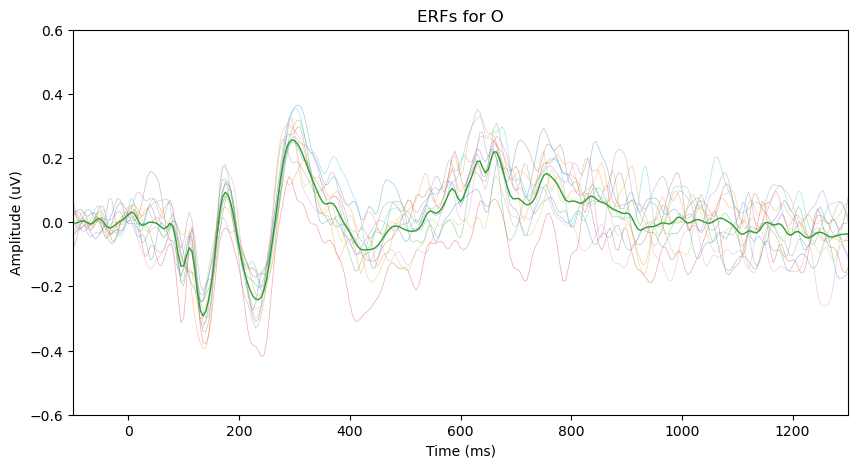

In [7]:
all_epochs = load_epochs(preproc_dir)
n_sessions = 12
plot_erfs(all_epochs[1],n_sessions,'O')
epochs = all_epochs[participant_no]

In [8]:

time_points = epochs.times
name = channel_picks[0]
print(name, channel_picks)
# ctf_layout = mne.find_layout(epochs.info)
picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
ep1 = epochs[epochs.metadata['trial_type']=='exp']  
ep1.load_data()
if OPTICAL_CHANNELS:
    NOS_CHANNELS_OPT = 39
    ep1.pick_channels(ch_names=picks_epochs); # supress output
else:
    NOS_CHANNELS_OPT = 271

O ['O', 'T', 'P']
Loading data for 22248 events and 281 original time points ...


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [9]:
# Initialize the concept_epochs array with zeros
concept_epochs = np.zeros((NOS_IMAGE_PER_CONCEPT, NOS_CONCEPTS, NOS_TIME_POINTS, NOS_CHANNELS_OPT))
category_nrs = ep1.metadata['category_nr'].to_numpy()
session_nrs = ep1.metadata['session_nr'].to_numpy()

# Precompute masks for categories and sessions
category_masks = [(category_nrs == (cat_nr + 1)) for cat_nr in range(NOS_CONCEPTS)]
session_masks = [(session_nrs == (img_nr + 1)) for img_nr in range(NOS_IMAGE_PER_CONCEPT)]

# Fill concept_epochs efficiently
for category_nr, category_mask in enumerate(category_masks):
    for img_nr, session_mask in enumerate(session_masks):
        mask = category_mask & session_mask
        concept_epochs[img_nr, category_nr, :, :] = ep1._data[mask].transpose(0, 2, 1)

In [10]:

concept_epochs = concept_epochs[:, :, (time_points >= time_window[0]) & (time_points <= time_window[1]), :]
time_points = time_points[(time_points >= time_window[0]) & (time_points <= time_window[1])]
NOS_TIME_POINTS = concept_epochs.shape[2]
print(NOS_TIME_POINTS)
average_concept_epochs = concept_epochs.mean(axis = 0)
print(average_concept_epochs.shape, concept_epochs.shape)


161
(1854, 161, 39) (12, 1854, 161, 39)


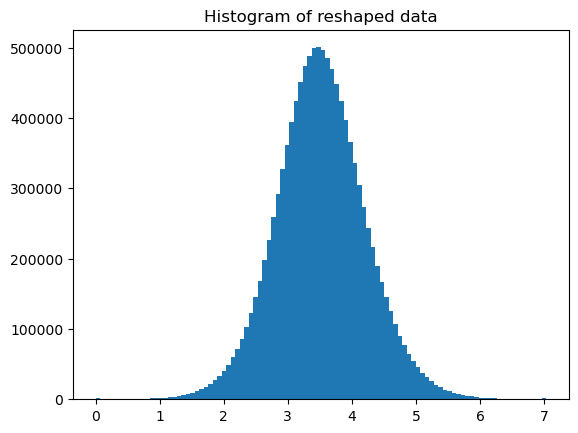

(1854, 6279)


In [11]:

temp = average_concept_epochs[:,:,:] - average_concept_epochs.mean(axis = (0,1)) # making sure each channel is centered
# set outlier points to max value 
dev = 5*np.std(temp)
temp[temp > dev] = dev
temp[temp < - dev] = - dev
temp = temp - np.min(temp)
plt.hist(temp.flatten(), bins = 100)
plt.title("Histogram of reshaped data")
plt.show()
X = temp.transpose(0,2,1).reshape(NOS_CONCEPTS, NOS_TIME_POINTS * NOS_CHANNELS_OPT) 
X = X - X.min()
print(X.shape) 


### Consensus NMF 

In [12]:
W, H = consensus_nmf_W(X, n_components=nmf_components, n_replicates=nos_seeds, p=0.3, tau=1, random_state=random_state)
print(W.shape, H.shape)

/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it t

0.6273302683005816
0.4029208657009332
0.7360227086481208
0.6746786389242037
0.39946123110442766
0.47219750972026525
0.8495035217261285
0.3331899701431221
0.3264774071243835
0.40511802273886743
0.18063314154425375
-0.2946650428834626
0.5174368711394595
0.5527539470837294
0.5226898113216317
Mean pairwise correlation: 0.44704992482244316
0.4668726695557628
0.6178174401374448
0.7222491262411479
0.794102293310831
0.5455287969472986
0.13684998459389658
0.5317121091095218
0.7071029524798942
-0.075045686454821
0.5052349551724693
0.7015180409537345
0.31375043884739223
0.6973491440407023
0.6484296595668906
0.29629108206590526
Mean pairwise correlation: 0.5073175337712047
0.6171044223249902
0.8082412504967662
-0.05403911340342549
0.6698282187717078
0.37563655758761416
0.05142035105946317
Mean pairwise correlation: 0.41136528113951926
0.181506427648266
-0.1309768910451603
0.09822207140961069
0.5676945272546445
-0.1310120539770175
0.00778227119353529
0.14751768464639328
0.5443503602941392
0.0776626

In [13]:

# nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
# for i in range(nmf_components):
#     sorted_indices = np.argsort(W[:,i])
#     print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
#     nmf_components_vs_category[i,:] = sorted_indices[-images_to_show:]
# # plot images for the top 5 categories for each component  
# category_array_name = []
# for component in range(nmf_components):
#     if component > 20:
#         break
#     print(f"Component {component} is best loaded by the following image categories:")
#     category_array = []
#     fig, axs = plt.subplots(1, images_to_show, figsize=(40, 40))
#     for i in range(images_to_show):
#         category_nr = nmf_components_vs_category[component, i] 
#         # Get the image paths for the given category_nr
#         image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
#         image_path = image_paths.iloc[0]
#         image_path = f'{image_dir}{image_path}'
#         img = mpimg.imread(image_path)
#         category_array.append(image_path.split('/')[-2])
#         axs[i].imshow(img)
#         axs[i].set_title(f"Category {category_nr}")
#         axs[i].axis('off')
#     plt.show()
#     category_array_name.append(category_array)

In [14]:
raise SystemExit("Stop here")

SystemExit: Stop here

/home/atharvsagar/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Time dynamics
To see how each component evolves with time

In [ ]:
# print(H.shape)
# comp_vs_time = H.reshape(nmf_components, NOS_CHANNELS_OPT, NOS_TIME_POINTS)

(6279, 5)


In [ ]:
   
# plt.figure(figsize=(20, 5)) 
# # plt.plot(time_points, average_concept_epochs[0, :, 0], label = 'original data', linewidth=2)
# # plt.plot(time_points, comp_vs_time[:, 0,:].sum(axis=0), label = 'NMF reconstruction', linewidth=2)
# for i in range(nmf_components):
#     plt.plot(time_points, comp_vs_time[i, 0,:], alpha=0.5, label=f'Component {i}')   
#     # plt.plot(time_points, comp_vs_time[i, 0,:] - comp_vs_time[i,0,:20].mean(), alpha=0.2, label=f'Component {i}')
# plt.title(f"Components vs time for participant {participant_no} and seed {random_state}")
# plt.xlabel("Time")
# plt.ylabel("Component value")
# plt.legend()
# plt.show()

In [ ]:
# plt.figure(figsize=(20, 5)) 
# plt.plot(time_points, comp_vs_time[:, 0,:].sum(axis = 0 ), alpha=0.5, label=f'Component sum')
# plt.show()

### Performing NNLS

In [ ]:
# print(X.shape, W.shape) 
# # reshape X to 3D
# X_scaled = X.reshape(NOS_CONCEPTS, NOS_CHANNELS_OPT, NOS_TIME_POINTS)
# # divide W by max value of each channel
# W_scaled = W / W.max(axis=0)
# nnls_results = np.zeros((nmf_components, NOS_CHANNELS_OPT, NOS_TIME_POINTS))    
# for channel in range(NOS_CHANNELS_OPT):
#     for t in range(NOS_TIME_POINTS):
#         nnls_results[:, channel, t] = nnls(W, X_scaled[:,channel,t])[0]

# print(nnls_results.shape)

In [ ]:
# # --- Example Plot ---
# # Plot the NNLS coefficient time series for channel 0 for all components.
# time_points = np.arange(NOS_TIME_POINTS)
# plt.figure(figsize=(20, 5))
# for comp in range(nmf_components):
#     plt.plot(time_points, nnls_results[comp, 0, :], alpha=0.7, label=f"Component {comp}")
# plt.title("NNLS Coefficients Over Time for Channel 0 (Locally Scaled)")
# plt.xlabel("Time (ms)")
# plt.ylabel("Coefficient (scaled)")
# plt.legend()
# plt.show()